# Decision Networks

In [1]:
using BayesNets
using DataFrames

  likely near C:\Users\Mykel\.julia\v0.6\IJulia\src\kernel.jl:31
  likely near C:\Users\Mykel\.julia\v0.6\IJulia\src\kernel.jl:31
  likely near C:\Users\Mykel\.julia\v0.6\IJulia\src\kernel.jl:31
  likely near C:\Users\Mykel\.julia\v0.6\IJulia\src\kernel.jl:31
  likely near C:\Users\Mykel\.julia\v0.6\IJulia\src\kernel.jl:31
  likely near C:\Users\Mykel\.julia\v0.6\IJulia\src\kernel.jl:31
  likely near C:\Users\Mykel\.julia\v0.6\IJulia\src\kernel.jl:31
  likely near C:\Users\Mykel\.julia\v0.6\IJulia\src\kernel.jl:31
  likely near C:\Users\Mykel\.julia\v0.6\IJulia\src\kernel.jl:31
  likely near C:\Users\Mykel\.julia\v0.6\IJulia\src\kernel.jl:31
  likely near C:\Users\Mykel\.julia\v0.6\IJulia\src\kernel.jl:31
  likely near C:\Users\Mykel\.julia\v0.6\IJulia\src\kernel.jl:31
  likely near C:\Users\Mykel\.julia\v0.6\IJulia\src\kernel.jl:31


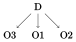

In [2]:
b = BayesNet()
push!(b, StaticCPD(:D, Bernoulli(0.01)))
push!(b, StaticCPD(:O1, [:D], Bernoulli(0.5))) # no real signal of whether disease is present
push!(b, FunctionalCPD{Bernoulli}(:O2, [:D], a->Bernoulli(a[:D] == true ? 0.9 : 0.01)))
push!(b, FunctionalCPD{Bernoulli}(:O3, [:D], a->Bernoulli(a[:D] == true ? 0.6 : 0.3)))

In [3]:
U = DataFrame()
U[:T] = [false, false, true, true]
U[:D] = [false, true, false, true]
U[:U] = [0, -10, -1, -1]
U

,T,D,U
1,false,false,0
2,false,true,-10
3,true,false,-1
4,true,true,-1


In [4]:
function BayesNets.estimate(b::BayesNet, target::NodeName, consistent_with::Assignment; nsamples = 10000)
    srand(0)
    t = estimate(rand_table_weighted(b, nsamples=nsamples, consistent_with=consistent_with))
    normalize(sumout(t, setdiff(names(b), [target])))
end;

In [5]:
# D = estimate(b, :D, Assignment(:O1=>true)) # FIXME

In [6]:
# EU = join(U, D, on = :D) # FIXME

In [7]:
# by(EU, :T, df->dot(df[:U], df[:p])) # FIXME

In [8]:
function diseaseEU(b::BayesNet, a::Assignment, U::DataFrame)
    D = estimate(b, :D, a)
    EU = join(U, D, on = :D)
    t = by(EU, :T, df->dot(df[:U], df[:p]))
    rename!(t, :x1, :EU)
    t
end;

In [9]:
# diseaseEU(b, Assignment(:O1=>true), U) # FIXME

In [10]:
# diseaseEU(b, Assignment(:O1=>false), U) # FIXME

In [11]:
# diseaseEU(b, Assignment(:O2=>true), U) # FIXME

In [12]:
# t = diseaseEU(b, Assignment(:O3=>true), U) # FIXME